<a href="https://colab.research.google.com/github/deoprakash/SapienRoboticsTask1/blob/main/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle tensorflow opencv-python

In [2]:
import kagglehub
path = kagglehub.dataset_download("huanghanchina/pascal-voc-2012")

100%|██████████| 3.63G/3.63G [00:40<00:00, 96.9MB/s]

Extracting files...


In [3]:
!mv "/root/.cache/kagglehub/datasets/huanghanchina/pascal-voc-2012/versions/1/VOC2012" "/content/"

In [4]:
import os
import cv2
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
import matplotlib.pyplot as plt
import numpy as np

In [34]:
data_dir = "/content/VOC2012"
img_size = 224
batch_size = 8
epochs = 40

In [35]:
classes = ["person", "car", "dog", "chair", "bicycle"]

class_to_id = {c: i for i, c in enumerate(classes)}
num_classes = len(classes)

In [36]:
def contains_selected_class(xml_path):
  root = ET.parse(xml_path).getroot()
  for obj in root.findall("object"):
    if obj.find("name").text in classes:
      return True
  return False

In [37]:
def get_filtered_ids(split):
  txt = os.path.join(data_dir, "ImageSets", "Main", f"{split}.txt")
  ids = open(txt).read().splitlines()

  filtered = []
  for img_id in ids:
    xml = os.path.join(data_dir, "Annotations", f"{img_id}.xml")
    if contains_selected_class(xml):
      filtered.append(img_id)

  return filtered

In [38]:
train_ids = get_filtered_ids("train")
val_ids = get_filtered_ids("val")

print("Train: ", len(train_ids))
print("Val: ", len(val_ids))

Train:  3427
Val:  3491


In [39]:
def load_sample(img_id):
  img_path = f"{data_dir}/JPEGImages/{img_id}.jpg"
  xml_path = f"{data_dir}/Annotations/{img_id}.xml"

  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  h, w, _ = image.shape

  root = ET.parse(xml_path).getroot()

  for obj in root.findall("object"):
    label = obj.find("name").text
    if label in classes:
      box = obj.find("bndbox")
      xmin = int(box.find("xmin").text) / w
      ymin = int(box.find("ymin").text) / h
      xmax = int(box.find("xmax").text) / w
      ymax = int(box.find("ymax").text) / h

      image = cv2.resize(image, (img_size, img_size))
      return image, class_to_id[label], [xmin, ymin, xmax, ymax]

  return None


In [40]:
def generator(ids):
  for img_id in ids:
    sample = load_sample(img_id)
    if sample:
      img, cls, bbox = sample
      yield img, {"class": cls, "bbox": bbox}

In [41]:
output_signature = (
    tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.uint8),
    {
        "class": tf.TensorSpec(shape=(), dtype=tf.int32),
        "bbox":tf.TensorSpec(shape=(4,), dtype=tf.float32)
    }
)

In [42]:
train_ds = tf.data.Dataset.from_generator(
    lambda: generator(train_ids),
    output_signature = output_signature
)

val_ds = tf.data.Dataset.from_generator(
    lambda: generator(val_ids),
    output_signature = output_signature
)

In [43]:
train_ds = train_ds.map(
    lambda x, y: (tf.cast(x, tf.float32)/255.0, y)
).shuffle(512).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(
    lambda x, y: (tf.cast(x, tf.float32)/255.0, y)
).shuffle(512).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [44]:
def build_detector():
    inputs = layers.Input(shape=(img_size, img_size, 3))

    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # ✅ THIS IS CRITICAL
    x = layers.GlobalAveragePooling2D()(x)

    # ✅ Classification head → (batch, num_classes)
    class_out = layers.Dense(
        num_classes, activation="softmax", name="class"
    )(x)

    # ✅ Bounding box head → (batch, 4)
    bbox_out = layers.Dense(
        4, activation="sigmoid", name="bbox"
    )(x)

    return models.Model(inputs, [class_out, bbox_out])


In [45]:
model = build_detector()

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss={
        "class":keras.losses.SparseCategoricalCrossentropy(),
        "bbox":keras.losses.Huber()
    },
    metrics={"class":"accuracy"}
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 28, 28,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ conv2d_7[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class (Dense)       │ (None, 5)         │      1,285 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox (Dense)        │ (None, 4)         │      1,028 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 390,729 (1.49 MB)

 Trainable params: 390,729 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/40
429/429 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - bbox_loss: 0.0332 - class_accuracy: 0.5801 - class_loss: 1.3027 - loss: 1.3359 - val_bbox_loss: 0.0266 - val_class_accuracy: 0.4887 - val_class_loss: 1.3975 - val_loss: 1.4238
Epoch 2/40
429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - bbox_loss: 0.0273 - class_accuracy: 0.5800 - class_loss: 1.1948 - loss: 1.2221 - val_bbox_loss: 0.0271 - val_class_accuracy: 0.4463 - val_class_loss: 1.3600 - val_loss: 1.3878
Epoch 3/40
429/429 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - bbox_loss: 0.0258 - class_accuracy: 0.5794 - class_loss: 1.1708 - loss: 1.1966 - val_bbox_loss: 0.0265 - val_class_accuracy: 0.5090 - val_class_loss: 1.2616 - val_loss: 1.2888
Epoch 4/40
429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - bbox_loss: 0.0258 - class_accuracy: 0.5755 - class_loss: 1.1369 - loss: 1.1627 - val_bbox_loss: 0.0257 - val_class_accuracy: 0.5004 - val_class_loss: 1.2603 - val_loss: 1.2854
Epoch 5/40
429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - bbox_loss: 0.025

In [47]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def infer_and_visualize(model, dataset, num_samples=5):
    for images, targets in dataset.take(1):
        preds_class, preds_bbox = model.predict(images)

        for i in range(min(num_samples, images.shape[0])):
            img = images[i].numpy()
            gt_bbox = targets["bbox"][i].numpy()
            gt_class = targets["class"][i].numpy()

            pred_bbox = preds_bbox[i]
            pred_class = preds_class[i].argmax()

            h, w, _ = img.shape

            fig, ax = plt.subplots(1)
            ax.imshow(img)

            # Ground Truth (GREEN)
            gx1, gy1, gx2, gy2 = gt_bbox
            rect_gt = patches.Rectangle(
                (gx1*w, gy1*h),
                (gx2-gx1)*w,
                (gy2-gy1)*h,
                linewidth=2,
                edgecolor='green',
                facecolor='none',
                label="GT"
            )
            ax.add_patch(rect_gt)

            # Prediction (RED)
            px1, py1, px2, py2 = pred_bbox
            rect_pred = patches.Rectangle(
                (px1*w, py1*h),
                (px2-px1)*w,
                (py2-py1)*h,
                linewidth=2,
                edgecolor='red',
                facecolor='none',
                label="Pred"
            )
            ax.add_patch(rect_pred)

            ax.set_title(
                f"GT: {classes[gt_class]} | Pred: {classes[pred_class]}"
            )
            plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


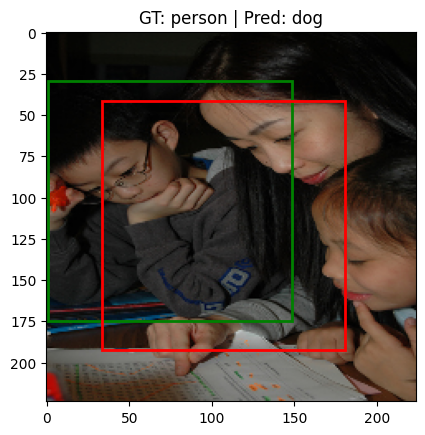

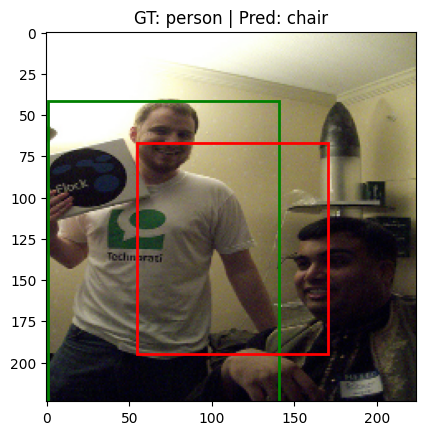

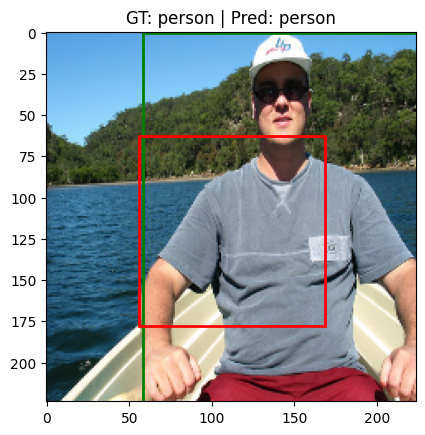

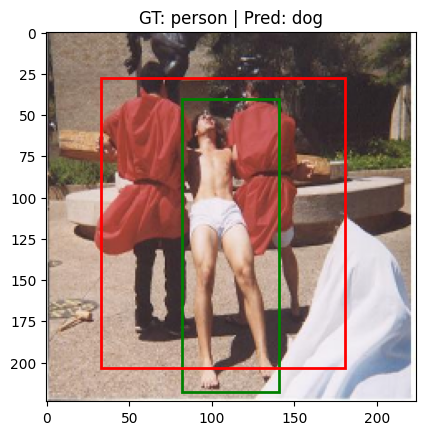

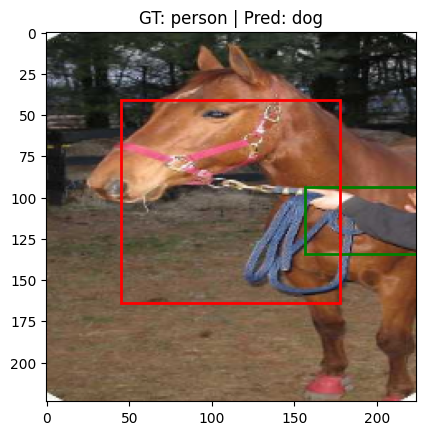

In [48]:
infer_and_visualize(model, val_ds)

In [49]:
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter = max(0, xB - xA) * max(0, yB - yA)
    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])

    return inter / (area1 + area2 - inter + 1e-6)


In [50]:
def compute_map(model, dataset, iou_threshold=0.5):
    true_positives = {c: 0 for c in range(num_classes)}
    false_positives = {c: 0 for c in range(num_classes)}
    total_gt = {c: 0 for c in range(num_classes)}

    for images, targets in dataset:
        pred_classes, pred_boxes = model.predict(images)

        for i in range(images.shape[0]):
            gt_class = targets["class"][i].numpy()
            gt_box = targets["bbox"][i].numpy()

            pred_class = pred_classes[i].argmax()
            pred_box = pred_boxes[i]

            total_gt[gt_class] += 1
            iou = compute_iou(gt_box, pred_box)

            if pred_class == gt_class and iou >= iou_threshold:
                true_positives[gt_class] += 1
            else:
                false_positives[pred_class] += 1

    ap = []
    for c in range(num_classes):
        if total_gt[c] == 0:
            continue
        precision = true_positives[c] / (true_positives[c] + false_positives[c] + 1e-6)
        ap.append(precision)

    return sum(ap) / len(ap)


In [51]:
map50 = compute_map(model, val_ds)
print("mAP@0.5:", map50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

In [52]:
import time

def measure_fps(model, dataset, num_batches=10):
    times = []
    for i, (images, _) in enumerate(dataset.take(num_batches)):
        start = time.time()
        model.predict(images)
        end = time.time()
        times.append(end - start)

    avg_time = sum(times) / len(times)
    fps = batch_size / avg_time
    return fps


In [53]:
fps = measure_fps(model, val_ds)
print("FPS:", fps)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
FPS: 91.12025361486451


In [54]:
model.save("detector_model.h5")


In [55]:
import os

size_mb = os.path.getsize("detector_model.h5") / (1024 * 1024)
print(f"Model size (MB): {size_mb:.2f}")


Model size (MB): 4.52


In [56]:
import os
import shutil
import xml.etree.ElementTree as ET
from tqdm import tqdm

# Paths
VOC_DIR = "/content/VOC2012"
IMG_DIR = os.path.join(VOC_DIR, "JPEGImages")
ANN_DIR = os.path.join(VOC_DIR, "Annotations")

OUTPUT_DIR = "/content/class_samples"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Classes you selected
CLASSES = ["person", "car", "dog", "chair", "bicycle"]

# Create class folders
for cls in CLASSES:
    os.makedirs(os.path.join(OUTPUT_DIR, cls), exist_ok=True)

# Track copied images to avoid duplicates
copied = {cls: set() for cls in CLASSES}

# Loop through annotations
xml_files = sorted(os.listdir(ANN_DIR))

for xml_file in tqdm(xml_files):
    xml_path = os.path.join(ANN_DIR, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    img_name = root.find("filename").text
    img_path = os.path.join(IMG_DIR, img_name)

    if not os.path.exists(img_path):
        continue

    # Find all classes in this image
    present_classes = set()
    for obj in root.findall("object"):
        label = obj.find("name").text
        if label in CLASSES:
            present_classes.add(label)

    # Copy image to corresponding class folders
    for cls in present_classes:
        if img_name not in copied[cls]:
            dst = os.path.join(OUTPUT_DIR, cls, img_name)
            shutil.copy(img_path, dst)
            copied[cls].add(img_name)

print("✅ Class-wise sample image creation completed!")


100%|██████████| 17125/17125 [00:13<00:00, 1254.42it/s]

✅ Class-wise sample image creation completed!


In [57]:
for cls in CLASSES:
    print(cls, ":", len(os.listdir(f"/content/class_samples/{cls}")))


person : 9583
car : 1284
dog : 1341
chair : 1366
bicycle : 603


In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [59]:
def predict_single_image(model, image_path, classes, img_size=224):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # Preprocess
    resized = cv2.resize(image, (img_size, img_size))
    input_img = resized.astype("float32") / 255.0
    input_img = np.expand_dims(input_img, axis=0)

    # Predict
    pred_class, pred_bbox = model.predict(input_img)

    class_id = np.argmax(pred_class[0])
    confidence = pred_class[0][class_id]

    xmin, ymin, xmax, ymax = pred_bbox[0]

    # Convert bbox to pixel coordinates
    x1 = int(xmin * w)
    y1 = int(ymin * h)
    x2 = int(xmax * w)
    y2 = int(ymax * h)

    # Plot
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    rect = patches.Rectangle(
        (x1, y1),
        x2 - x1,
        y2 - y1,
        linewidth=2,
        edgecolor="red",
        facecolor="none"
    )
    ax.add_patch(rect)

    ax.set_title(
        f"Pred: {classes[class_id]} | Confidence: {confidence:.2f}"
    )
    plt.show()

    return {
        "predicted_class": classes[class_id],
        "confidence": float(confidence),
        "bbox_pixels": (x1, y1, x2, y2)
    }


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


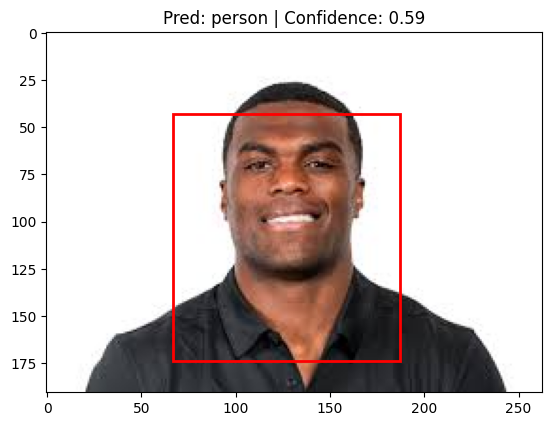

{'predicted_class': 'person', 'confidence': 0.5907946825027466, 'bbox_pixels': (67, 43, 187, 174)}


In [69]:
test_image = "/content/download.jpg"
result = predict_single_image(
    model=model,
    image_path=test_image,
    classes=classes,
    img_size=img_size
)

print(result)
